<a href="https://colab.research.google.com/github/yxmauw/eye-disease-classification/blob/main/NasNetLarge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://imgur.com/1ZcRyrc.png" width="70" height="70" align="left" style="margin: 20px"> 
 # Capstone: Eye Disease Classification using Fundoscopy images

## Setting up local directory to work
Stream data direct from kaggle using Kaggle API

In [ ]:
# install kaggle API if never done before for your google account
# !pip install kaggle

In [2]:
!git clone https://github.com/yxmauw/eye-disease-classification.git

Cloning into 'eye-disease-classification'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 315 (delta 103), reused 129 (delta 73), pack-reused 134
Receiving objects: 100% (315/315), 56.15 MiB | 32.16 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [3]:
!mkdir ~/.kaggle #Make a directory named “.kaggle”

In [4]:
!cp ./eye-disease-classification/kaggle.json ~/.kaggle/ # Copy the “kaggle.json” into this new directory

In [5]:
!chmod 600 ~/.kaggle/kaggle.json # Allocate the required permission for this file

In [6]:
!kaggle datasets download gunavenkatdoddi/eye-diseases-classification # download dataset

 99% 729M/736M [00:05<00:00, 134MB/s]
100% 736M/736M [00:05<00:00, 146MB/s]


In [ ]:
!unzip eye-diseases-classification.zip

## Explore images

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

### Number of images in dataset:

In [9]:
import fnmatch
import os

# image files count
cataract_count = len(fnmatch.filter(os.listdir('./dataset/cataract'), '*.*'))
dre_count = len(fnmatch.filter(os.listdir('./dataset/diabetic_retinopathy'), '*.*'))
glaucoma_count = len(fnmatch.filter(os.listdir('./dataset/glaucoma'), '*.*'))
normal_count = len(fnmatch.filter(os.listdir('./dataset/normal'), '*.*'))
total_image_count = cataract_count + dre_count + \
                    glaucoma_count + normal_count
# print count
print('---Categories---')
print('Cataract:', cataract_count)
print('Diabetic retinopathy:', dre_count)
print('Glaucoma:', glaucoma_count)
print('Normal', normal_count)
print()
print('---Total image count---')
print(total_image_count)

---Categories---
Cataract: 1038
Diabetic retinopathy: 1098
Glaucoma: 1007
Normal 1074

---Total image count---
4217


### Image dimensions, properties:

In [10]:
# load example image
from PIL import Image 
im = Image.open('./dataset/glaucoma/1495_left.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size) # size already 512 x 512

pixels = np.asarray(im)
print(pixels[0])
print(pixels.shape) # 3 channel last

JPEG
RGB
(512, 512)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
(512, 512, 3)


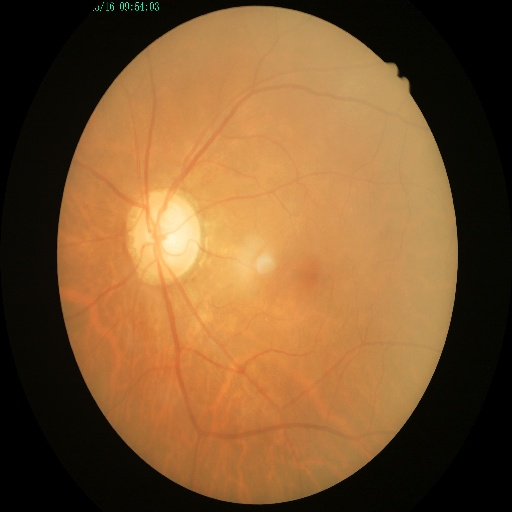

In [ ]:
#Import library
from IPython import display
display.Image(filename='./dataset/glaucoma/1495_left.jpg', width=200, height=150)

In [ ]:
# calculate image pixel mean, min, max

mean = pixels.mean()
print('Mean: %.3f' % mean)
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Mean: 86.173
Min: 0.000, Max: 255.000


## Visualise preprocessed images

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__) #2.8.2

2.8.2


What happens after resizing and rescaling: 

In [ ]:
resize_and_rescale = tf.keras.Sequential([   
    layers.Resizing(331,331) ,  # needs to be symmetrical, specific size for nasnetlarge
    layers.Rescaling(1./255) # desired height, width in model pipeline
])

result = resize_and_rescale(pixels)
print(result.shape) # new shape, channels

(331, 331, 3)


What happens to image pixel values after rescaling:

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


Show images before and after preprocessing:

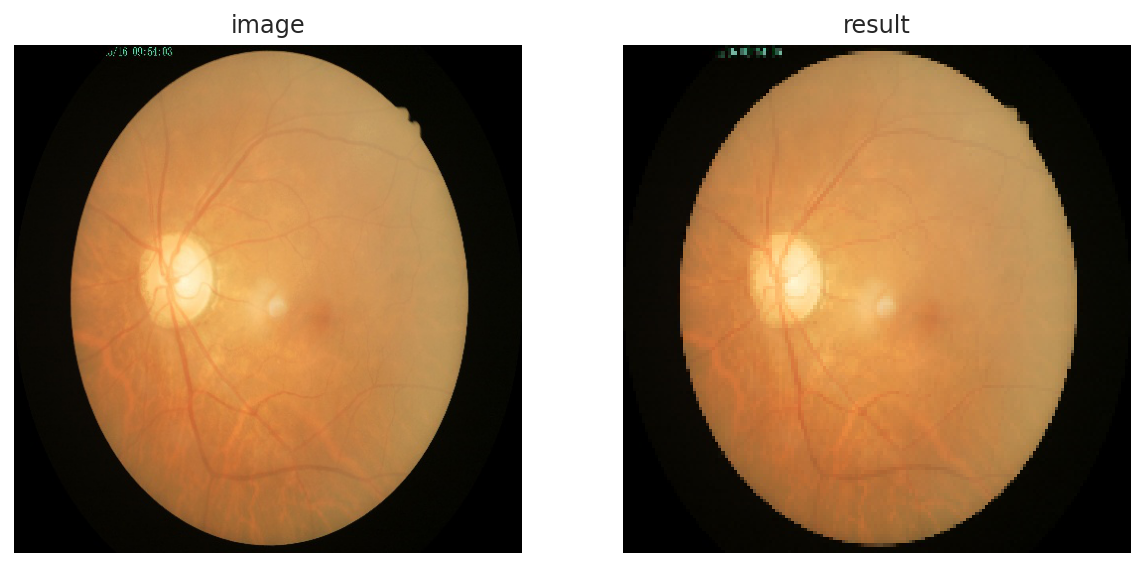

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(result)
ax1.axis('off')
ax1.set_title('result')
plt.show() # result seems to have slight blurring of image, but still good definition

## Create train, validation and test datasets

In [12]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# first allocate a test set using this library
import splitfolders

splitfolders.ratio('./dataset/', output="./work_directory/", seed=1, ratio=(.5,.25,.25))

Copying files: 4217 files [00:03, 1251.35 files/s]


In [14]:
# generate dataset that can be used for machine learning
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (331, 331) # very important to get this right, will determine model success
batch_size = 32

train_ds = image_dataset_from_directory(
    './work_directory/train',
    image_size=image_size,
    shuffle=True,
    labels='inferred',
    seed=1,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    './work_directory/val',
    image_size=image_size,
    shuffle=True,
    labels='inferred',
    seed=1,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory( # for model evaluation later
    './work_directory/test',
    image_size=image_size,
    labels='inferred',
    seed=1,
    shuffle=False,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 2108 files belonging to 4 classes.
Found 1052 files belonging to 4 classes.
Found 1057 files belonging to 4 classes.


In [15]:
# preview of how images are labelled
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


### Visualise images and labels together

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


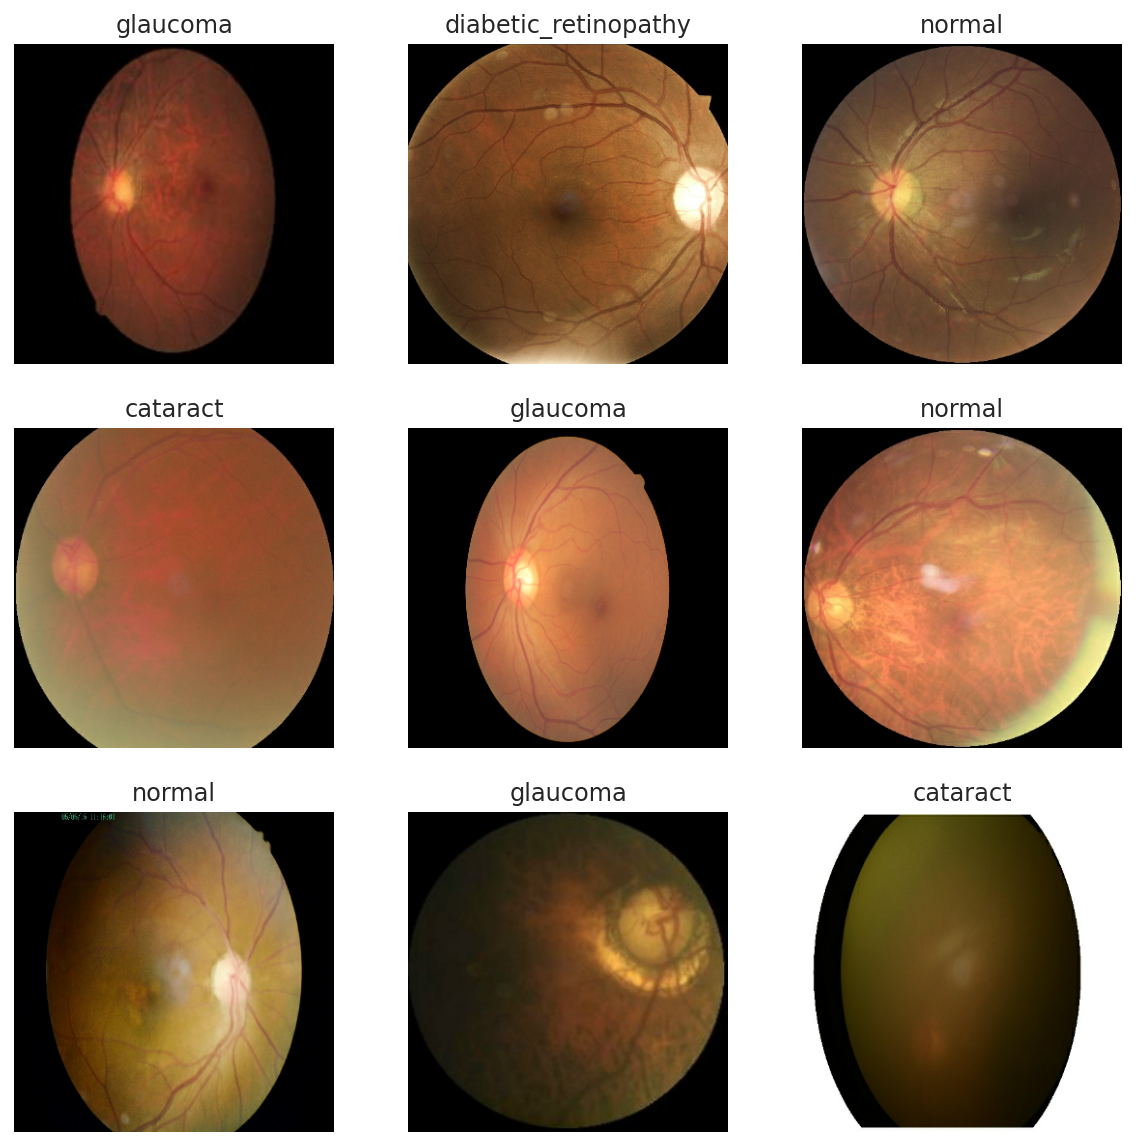

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # each image 160 x 160
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i], axis=0)])
    plt.axis("off")

## Data augmentation

In [16]:
data_augmentation = tf.keras.Sequential(
    [ layers.RandomFlip("horizontal"), 
      layers.RandomRotation(0.1),
      layers.RandomContrast(0.1)
    ])

### Visualise augmented images

In [ ]:
def augmented_img():
  for image, _ in train_ds.take(1):  # take a sample image from training set
    plt.figure(figsize=(8, 8))
    first_image = image[0]
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      plt.imshow(augmented_image[0] / 255) # rescale pixel 0 to 1
      plt.axis("off")

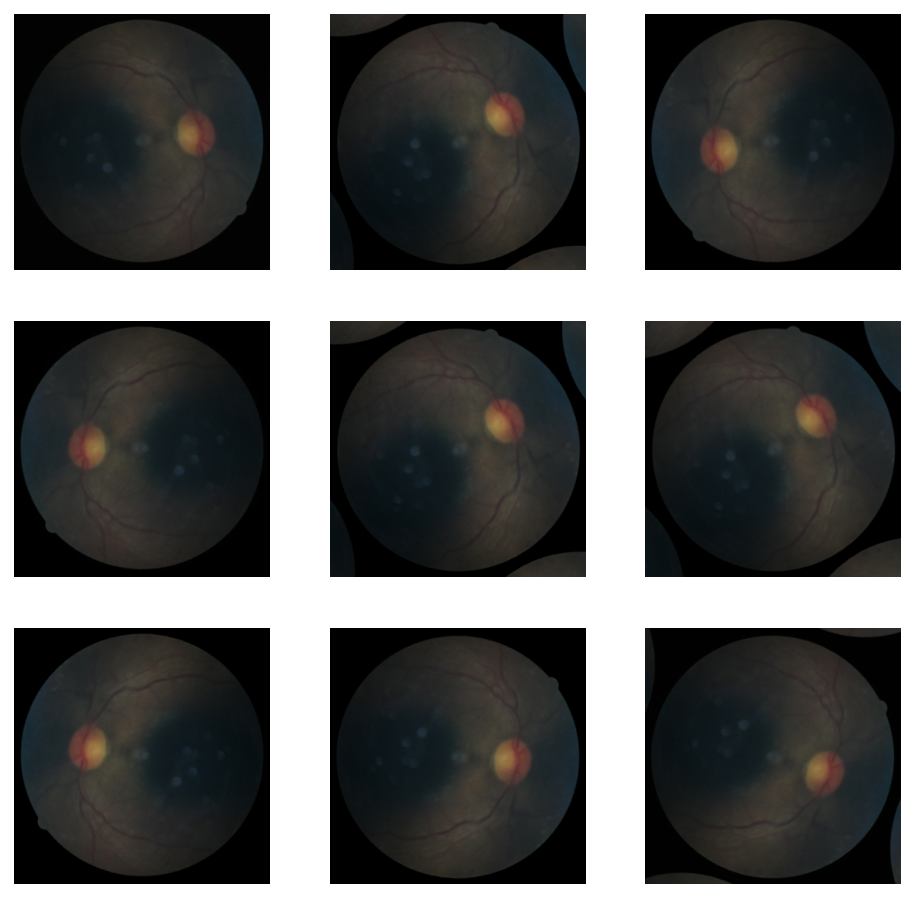

In [ ]:
augmented_img()

## Create Base NasNetLarge model

[getting F1 score in metrics](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d)


In [17]:
import keras.backend as K # function to add F1 score as metric

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score
]

In [20]:
from tensorflow.keras.layers import (Dense, Activation, Dropout, Conv2D, 
                                     MaxPooling2D, BatchNormalization)
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [21]:
input_shape = (331, 331, 3)
base_model = tf.keras.applications.NASNetLarge(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet',
                                                 pooling='max'
                                                 )
base_model.trainable=True # train entire model layers, yet with pre-trained weights from ImageNet

343621632/343610240 [==============================] - 3s 0us/step


In [23]:
# Create the base model from the pre-trained NASNetLarge model
def NasNetL():
  input_shape = (331, 331, 3)
  base_model = tf.keras.applications.NASNetLarge(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet',
                                                 pooling='max'
                                                 )
  base_model.trainable=True # train entire model layers, yet with pre-trained weights from ImageNet
  x = base_model.output
  x = tf.keras.layers.Rescaling(1./255)(x) # rescaling layer
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x = Dropout(rate=.4, seed=123)(x)       
  output = Dense(4, activation='softmax')(x)
  # instantiate model with added layers
  model=Model(inputs=base_model.input, outputs=output)
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss='categorical_crossentropy', 
                metrics=METRICS) 
  return model

In [24]:
model = NasNetL()

In [ ]:
model.summary()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# show model in graph manner
tf.keras.utils.plot_model(model, to_file = "drive/MyDrive/Colab Notebooks/NasNetLarge.png", show_shapes=True)

## Compile, fit model, run

In [1]:
# Train the model, doing validation at the end of each epoch.
epochs = 100 

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/NasNet_ep{epoch}_val{val_loss:.3f}", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/NasNet_history.csv'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,mode='min',min_lr=0.00001)
]

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

NameError: ignored

## Learning Curves 

In [ ]:
history = pd.read_csv('drive/MyDrive/Colab Notebooks/NasNet_history.csv')
history.head(3)

,epoch,auc,categorical_accuracy,f1_score,loss,precision,recall,val_auc,val_categorical_accuracy,val_f1_score,val_loss,val_precision,val_recall
0,0,0.932274,0.791455,0.782472,6.825202,0.813522,0.758901,0.977095,0.887039,0.884039,4.033412,0.897686,0.876338
1,1,0.971640,0.870125,0.866327,2.611241,0.892473,0.844354,0.956279,0.794293,0.787771,1.707596,0.867332,0.722949
2,2,0.986344,0.918277,0.915084,1.093672,0.930853,0.899288,0.979914,0.910820,0.907845,0.877249,0.917973,0.904875


In [ ]:
acc = history['categorical_accuracy']
val_acc = history['val_categorical_accuracy']

loss = history['loss']
val_loss = history['val_loss']

In [ ]:
def learning_curves(acc,val_acc,loss,val_loss):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())])
  plt.xlim([0,max(plt.xlim())])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())])
  plt.xlim([0,max(plt.xlim())])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
  return plt.show()

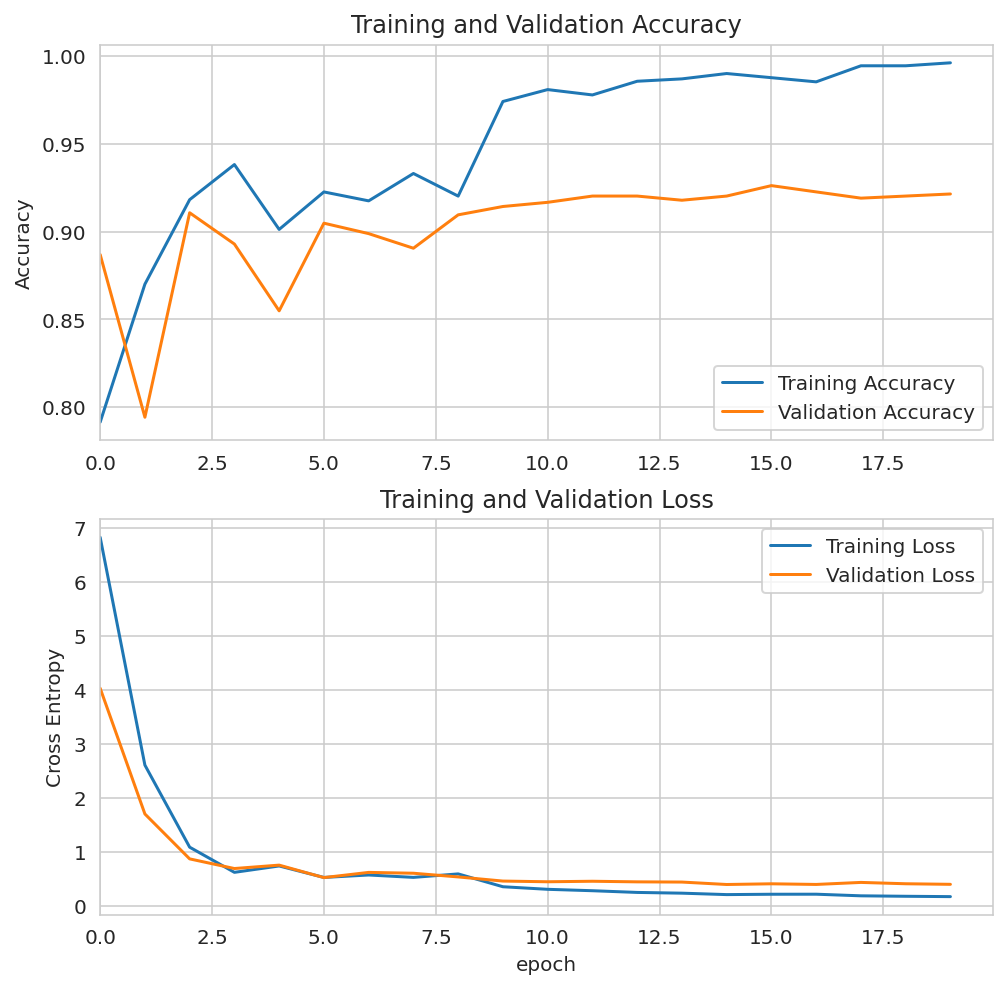

In [ ]:
learning_curves(acc,val_acc,loss,val_loss)

In [ ]:
# check for generalisation for epoch 6
def eval_metrics(epoch_num):
  val_auc = history.loc[history['epoch']==epoch_num, ['val_auc']].values[0][0]
  auc = history.loc[history['epoch']==epoch_num, ['auc']].values[0][0]
  auc_diff = (auc - val_auc)*100 / auc
  print('AUC percentage difference is:', abs(auc_diff), '%')

  val_acc = history.loc[history['epoch']==epoch_num, ['val_categorical_accuracy']].values[0][0]
  acc = history.loc[history['epoch']==epoch_num, ['categorical_accuracy']].values[0][0]
  acc_diff = (acc - val_acc)*100 / acc
  print()
  print('Accuracy percentage difference is:', abs(acc_diff), '%')

In [ ]:
eval_metrics(epoch_num=15) # 8 because record epoch 16 as 15

AUC percentage difference is: 1.6267341234828752 %

Accuracy percentage difference is: 6.227447453622913 %


In [ ]:
eval_metrics(epoch_num=8) # epoch 9 model has best combi metrics of acc and generalisation

AUC percentage difference is: 0.1247333394795323 %

Accuracy percentage difference is: 1.1605429515397576 %


Model at epoch 16 may be regarded as best performing base NasNetLarge model based on lowest validation loss, however it is overfitted.

By sacrificing a bit of validation loss to achieve generalisation within 5%, model at epoch 9 would be the best performing base NasNetLarge model. 

NasNetLarge model at epoch 9 has the following validation metrics:

| Name                |   Scores   |
|:--------------------|:----------:|
|AUC                  |0.9852296114|
|Categorical Accuracy |0.9096313715|
|F1 score             |0.9045333266|
|Loss                 |0.5435038805|
|Precision            |0.9119421244|
|Recall               |0.8989298344|


## NasNet model with augmentation layers

adding data augmentation layers, try running NasNet with data augmentation layers, and see if can get better performance, yet still maintain model generalisation.

In [ ]:
 # add rescaling layer to base model
 def NasNet_augmented():
  inputs = tf.keras.Input(shape=(331, 331, 3))
  x = data_augmentation(inputs) # augmentation layer
  x = tf.keras.layers.Rescaling(1./255)(x) # rescaling layer
  x = base_model(x, training=True)
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
  x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
  x = Dropout(rate=.4, seed=123)(x)       
  output = Dense(4, activation='softmax')(x)
  # instantiate model with added layers
  model = tf.keras.Model(inputs, output)
  return model

In [ ]:
model = NasNet_augmented()

In [ ]:
model.summary()

## Compile, fit model, run

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="categorical_crossentropy", # match label_mode='categorical'
              metrics=METRICS)

# Train the model, doing validation at the end of each epoch.
epochs = 100 

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/NasNet_augm_ep{epoch}_val{val_loss:.3f}", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/NasNet_history_augm.csv'), # save history
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,mode='min',min_lr=0.00001)
]

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
93/93 [==============================] - 1356s 14s/step - loss: 7.2823 - categorical_accuracy: 0.7206 - precision: 0.7491 - recall: 0.6812 - auc: 0.8850 - f1_score: 0.7101 - val_loss: 5.3226 - val_categorical_accuracy: 0.7229 - val_precision: 0.7304 - val_recall: 0.6992 - val_auc: 0.8715 - val_f1_score: 0.7125 - lr: 0.0010
Epoch 2/100
93/93 [==============================] - 1319s 14s/step - loss: 3.0756 - categorical_accuracy: 0.8376 - precision: 0.8638 - recall: 0.8020 - auc: 0.9527 - f1_score: 0.8316 - val_loss: 2.0144 - val_categorical_accuracy: 0.8763 - val_precision: 0.8869 - val_recall: 0.8668 - val_auc: 0.9719 - val_f1_score: 0.8751 - lr: 0.0010
Epoch 3/100
93/93 [==============================] - 1332s 14s/step - loss: 1.4275 - categorical_accuracy: 0.8715 - precision: 0.8921 - recall: 0.8386 - auc: 0.9695 - f1_score: 0.8633 - val_loss: 0.9754 - val_categorical_accuracy: 0.8918 - val_precision: 0.9015 - val_recall: 0.8704 - val_auc: 0.9800 - val_f1_score: 0.8854 - 

## Learning Curves 

In [ ]:
history = pd.read_csv('drive/MyDrive/Colab Notebooks/NasNet_history_augm.csv')
history.head(3)

,epoch,auc,categorical_accuracy,f1_score,loss,precision,recall,val_auc,val_categorical_accuracy,val_f1_score,val_loss,val_precision,val_recall
0,0,0.884955,0.720583,0.710074,7.282326,0.749068,0.681248,0.871456,0.722949,0.712511,5.322598,0.730435,0.699168
1,1,0.952703,0.837572,0.831601,3.075566,0.863769,0.801967,0.971934,0.876338,0.875079,2.014353,0.886861,0.866825
2,2,0.969461,0.871482,0.863290,1.427534,0.892136,0.838589,0.980024,0.891795,0.885432,0.975360,0.901478,0.870392


In [ ]:
acc = history['categorical_accuracy']
val_acc = history['val_categorical_accuracy']

loss = history['loss']
val_loss = history['val_loss']

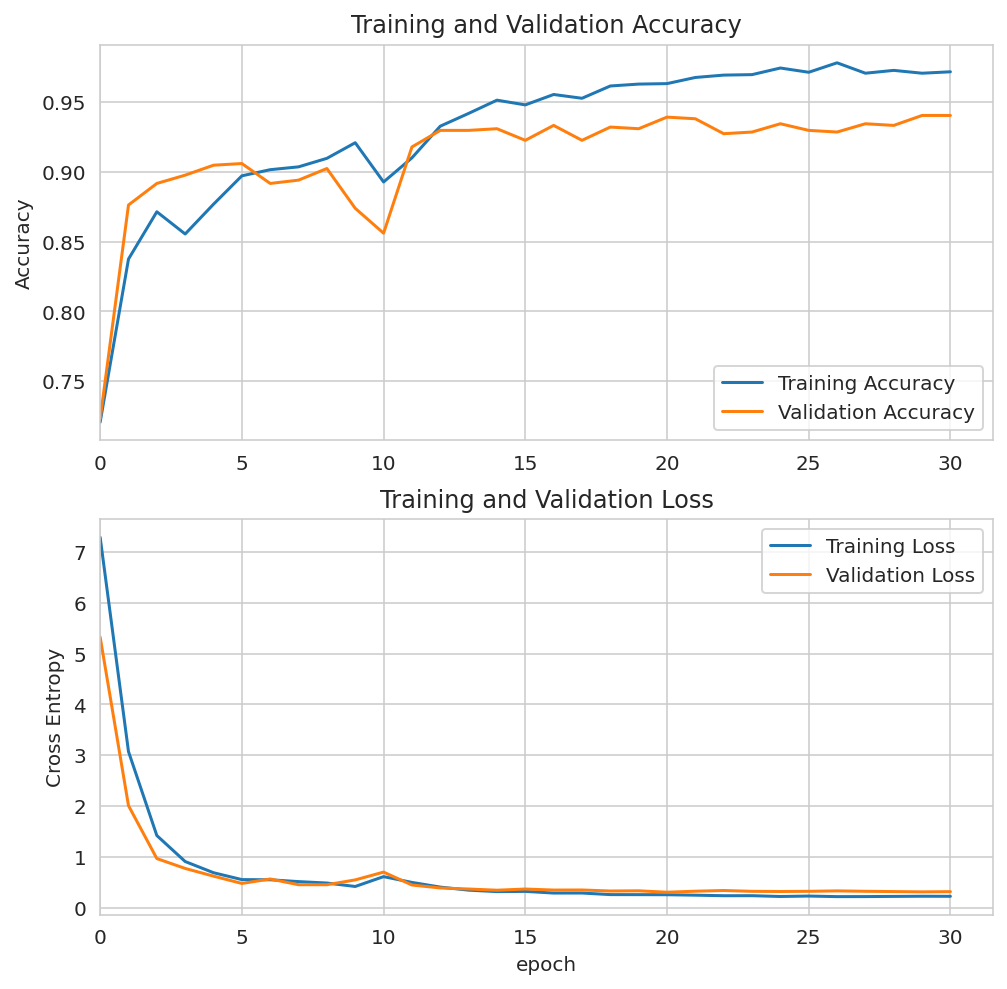

In [ ]:
learning_curves(acc,val_acc,loss,val_loss)

In [ ]:
# check for generalisation using epoch 21
eval_metrics(epoch_num=20)

AUC percentage difference is: 0.27728240021201966 %

Accuracy percentage difference is: 2.493257507320375 %


After adding data augmentation layers, the NasNetLarge model is able to train to a lower validation loss compared to the base model. Model accuracy is generalised within 5%.

Validation metrics of the final augmented NasNetLarge model are as follows:

| Name                |   Scores   |
|:--------------------|:----------:|
|AUC                  |0.9929341674|
|Categorical Accuracy |0.9393579364|
|F1 score             |0.9403291345|
|Loss                 |0.314869225|
|Precision            |0.9403341413|
|Recall               |0.9369797707|

## Evaluation

Using test dataset and best performing NasNetLarge model with data augmentation layers.

__References:__
1. [images](https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/)
1. [kaggle code](https://www.kaggle.com/code/gpiosenka/eye-disease-f1-score-92-6/notebook)

In [ ]:
# choose model for evaluation
# load model
model = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks/NasNet_augm_ep21_val0.315", 
                                   custom_objects={'f1_score': f1_score})

### Plot confusion matrix for train, validation and test sets

[Multiclass confusion matrix](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/#:~:text=Confusion%20Matrix%20is%20used%20to,number%20of%20classes%20or%20outputs.)


In [ ]:
# get predictions for confusion matrix
# class_names = train_ds.class_names # from previous cell
print(class_names)

print('===== test_ds predictions =====')
test_preds = model.predict(test_ds, verbose=1) # get test_ds predictions
# sample test_ds predictions
print(test_preds[:1])
for array in test_preds:
  print(f'{class_names[0]} probability is: {array[0]:.4f}')
  print(f'{class_names[1]} probability is: {array[1]:.4f}')
  print(f'{class_names[2]} probability is: {array[2]:.4f}')
  print(f'{class_names[3]} probability is: {array[3]:.4f}')
  break

print() #gap

print('===== train_ds predictions =====')
train_preds = model.predict(train_ds, verbose=1) # get train_ds predictions
# sample train_ds predictions
print(train_preds[:1])
for array in train_preds:
  print(f'{class_names[0]} probability is: {array[0]:.4f}')
  print(f'{class_names[1]} probability is: {array[1]:.4f}')
  print(f'{class_names[2]} probability is: {array[2]:.4f}')
  print(f'{class_names[3]} probability is: {array[3]:.4f}')
  break

print() #gap

print('===== val_ds predictions =====')
val_preds = model.predict(val_ds, verbose=1) # get val_ds predictions
# sample val_ds predictions
print(val_preds[:1])
for array in val_preds:
  print(f'{class_names[0]} probability is: {array[0]:.4f}')
  print(f'{class_names[1]} probability is: {array[1]:.4f}')
  print(f'{class_names[2]} probability is: {array[2]:.4f}')
  print(f'{class_names[3]} probability is: {array[3]:.4f}')
  break

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
===== test_ds predictions =====
14/14 [==============================] - 65s 5s/step
[[0.02153889 0.1561203  0.07992139 0.7424194 ]]
cataract probability is: 0.0215
diabetic_retinopathy probability is: 0.1561
glaucoma probability is: 0.0799
normal probability is: 0.7424

===== train_ds predictions =====
93/93 [==============================] - 537s 6s/step
[[0.98939896 0.0011264  0.00465935 0.00481537]]
cataract probability is: 0.9894
diabetic_retinopathy probability is: 0.0011
glaucoma probability is: 0.0047
normal probability is: 0.0048

===== val_ds predictions =====
27/27 [==============================] - 155s 6s/step
[[0.01937345 0.01045565 0.04797944 0.9221915 ]]
cataract probability is: 0.0194
diabetic_retinopathy probability is: 0.0105
glaucoma probability is: 0.0480
normal probability is: 0.9222


In [ ]:
# convert probabilities into ohe
# for confusion matrix

# for test_ds
idx = np.argmax(test_preds, axis=-1)
test_preds = np.zeros( test_preds.shape ) 
test_preds[ np.arange(test_preds.shape[0]), idx] = 1  

#print(train_preds.argmax(axis=1))
#print(train_labels.argmax(axis=1))

# for train_ds
idx = np.argmax(train_preds, axis=-1)
train_preds = np.zeros( train_preds.shape ) 
train_preds[ np.arange(train_preds.shape[0]), idx] = 1  

# for val_ds
idx = np.argmax(val_preds, axis=-1)
val_preds = np.zeros( val_preds.shape ) 
val_preds[ np.arange(val_preds.shape[0]), idx] = 1  

print('Predicted test_ds labels:', test_preds[:5])
print() # gap
print('Predicted train_ds labels:', train_preds[:5])
print() # gap
print('Predicted val_ds labels:', val_preds[:5])

Predicted test_ds labels: [[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]

Predicted train_ds labels: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]

Predicted val_ds labels: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# extract true labels and images from test_ds
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
test_images = np.concatenate([x for x, y in test_ds], axis=0)

# extract true labels and images from train_ds
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
train_images = np.concatenate([x for x, y in train_ds], axis=0)

# extract true labels and images from val_ds
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_images = np.concatenate([x for x, y in val_ds], axis=0)

print('===== Test set true labels =====') 
print(test_labels[:5])
print() # gap
print('===== Train set true labels =====')
print(train_labels[:5])
print() # gap
print('===== Validation set true labels =====')
print(val_labels[:5])

===== Test set true labels =====
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]

===== Train set true labels =====
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]

===== Validation set true labels =====
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [ ]:
from sklearn.metrics import confusion_matrix
# Creating a confusion matrix for test_ds predictions
test_cm = confusion_matrix(test_labels.argmax(axis=1), test_preds.argmax(axis=1))
# Creating a confusion matrix for train_ds predictions
train_cm = confusion_matrix(train_labels.argmax(axis=1), train_preds.argmax(axis=1))
# Creating a confusion matrix for val_ds predictions
val_cm = confusion_matrix(val_labels.argmax(axis=1), val_preds.argmax(axis=1))

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
test_cm_df = pd.DataFrame(test_cm,
                          index = class_names, 
                          columns = class_names)
train_cm_df = pd.DataFrame(train_cm,
                           index = class_names, 
                           columns = class_names)
val_cm_df = pd.DataFrame(val_cm,
                         index = class_names, 
                         columns = class_names)

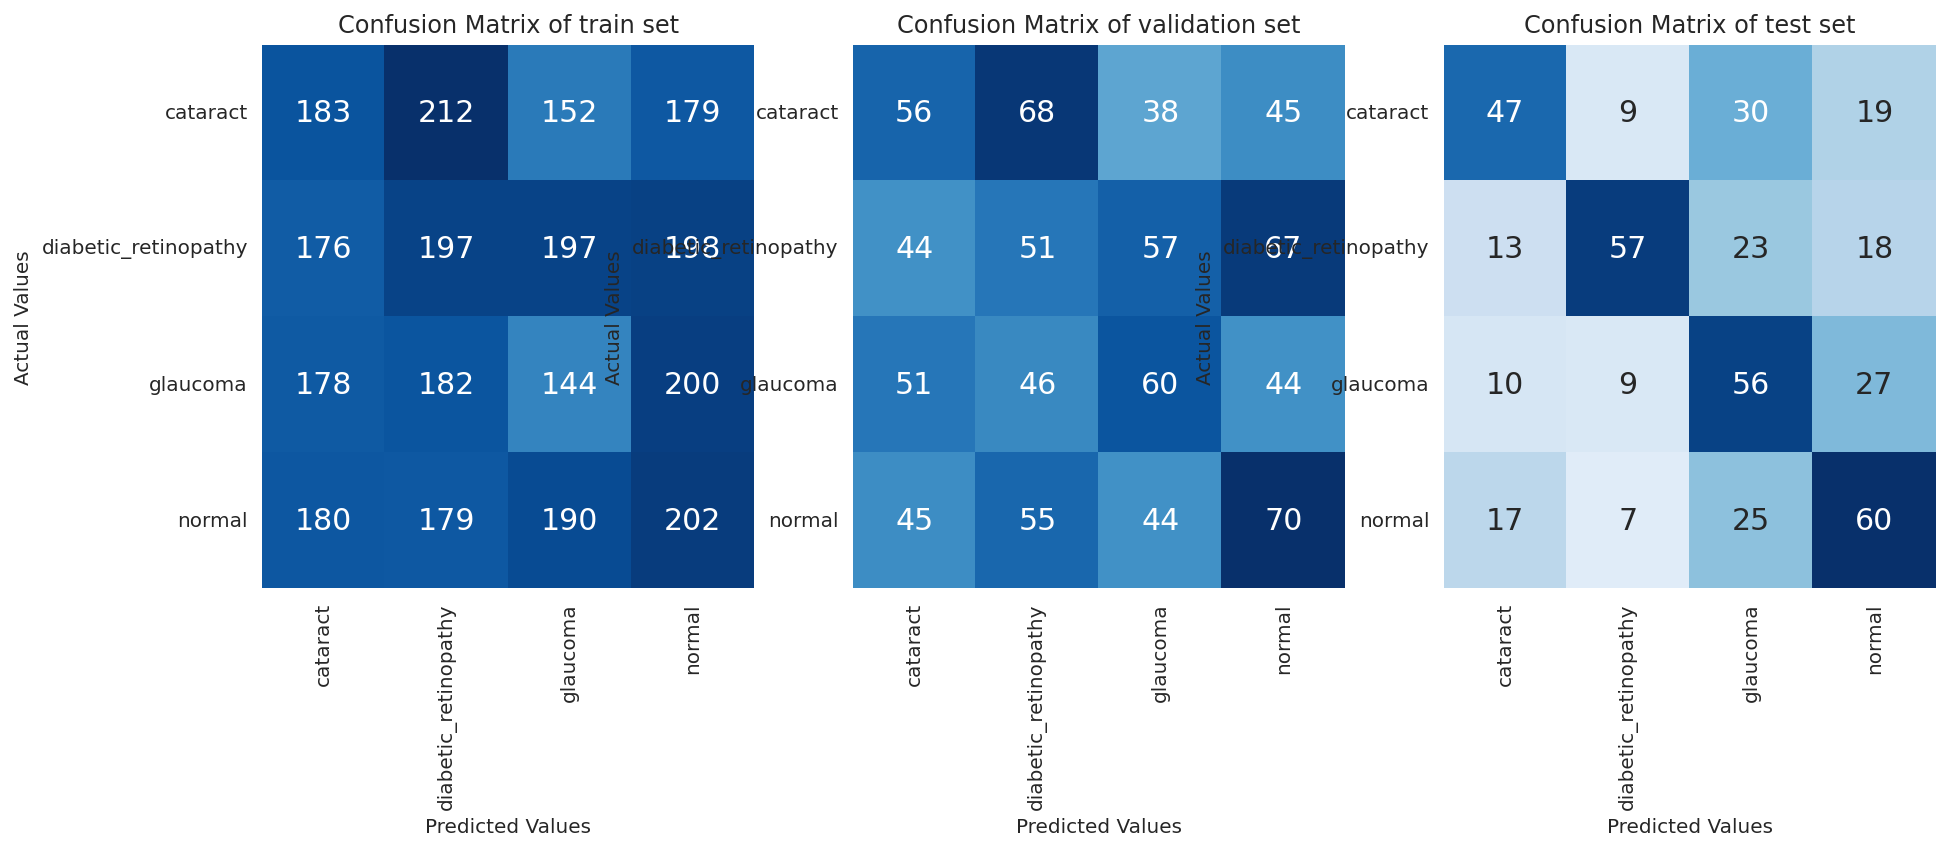

In [ ]:
#Plotting confusion matrix using heatmap
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.heatmap(train_cm_df, annot=True, cbar=False, cmap='Blues', vmin=0, fmt='.3g', annot_kws={"size": 15}, ax=axes[0])
axes[0].set_title('Confusion Matrix of train set')
axes[0].set_ylabel('Actual Values')
axes[0].set_xlabel('Predicted Values')

sns.heatmap(val_cm_df, annot=True, cbar=False, cmap='Blues', vmin=0, fmt='.3g', annot_kws={"size": 15}, ax=axes[1])
axes[1].set_title('Confusion Matrix of validation set')
axes[1].set_ylabel('Actual Values')
axes[1].set_xlabel('Predicted Values')

sns.heatmap(test_cm_df, annot=True, cbar=False, cmap='Blues', vmin=0, fmt='.3g', annot_kws={"size": 15}, ax=axes[2])
axes[2].set_title('Confusion Matrix of test set')
axes[2].set_ylabel('Actual Values')
axes[2].set_xlabel('Predicted Values')

plt.show()

### Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels, val_preds, target_names=class_names, digits= 4))

                      precision    recall  f1-score   support

            cataract     0.2368    0.2174    0.2267       207
diabetic_retinopathy     0.2432    0.2466    0.2449       219
            glaucoma     0.2335    0.2289    0.2312       201
              normal     0.2500    0.2710    0.2601       214

           micro avg     0.2414    0.2414    0.2414       841
           macro avg     0.2409    0.2410    0.2407       841
        weighted avg     0.2411    0.2414    0.2410       841
         samples avg     0.2414    0.2414    0.2414       841



Model is not great at identifying glaucoma compared to other conditions, which makes sense due to the lowest support in the dataset. The model is best at identifying diabetic retinopathy.

## Misclassified test images

In [ ]:
image_list = np.concatenate(image_list) # numpy array representation of images

In [ ]:
# extract test file names from test_ds 
# glitchy code, sometimes can run sometimes throw error, not sure why
test_filenames = test_ds.file_paths

In [ ]:
len(test_filenames)

214

In [ ]:
# convert OHE to class_names for easier comparison 
y_true_labels = tf.argmax(y_true, axis=1).numpy() # tensor object not iterable, use numpy to convert to list
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()

error_list = []

for a, b, c in zip(y_true_labels, y_pred_labels, test_filenames):
  if a != b:
    error_list.append((a,b,c))

In [ ]:
len(error_list)

98

In [ ]:
error_list[:5] # check for duplicates

[(0, 1, './work_directory/test/cataract/1084_right.jpg'),
 (0, 1, './work_directory/test/cataract/112_right.jpg'),
 (0, 2, './work_directory/test/cataract/1456_left.jpg'),
 (0, 3, './work_directory/test/cataract/1484_left.jpg'),
 (0, 3, './work_directory/test/cataract/1987_left.jpg')]

In [ ]:
# to display 3 example of each class that was wrongly classified

fig, axes = plt.subplots(4, 5, figsize=(8, 15))

for true_label, pred_label, f_path, ax in zip(error_list, axes.ravel()): 
  img = Image.open(f_path)
  ax.imshow(img)
    
  #plt.imshow(image.astype('uint8'))
  #for i in range(10):
    #ax[i].imshow(image.astype('uint8'))
    
    #plt.title(class_names[true_label[i]])
    #plt.subtitle(class_names[pred_label[i]])
    #plt.axis("off")
'''
for images, labels in train_ds.take(1): # each image 160 x 160
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i], axis=0)])
    plt.axis("off")
'''

In [ ]:
# compare images with true vs predicted labels

In [ ]:
for images, labels in train_ds.take(1): # each image 160 x 160
 # print(images[i])
  print(images[i].numpy())
  break

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


### ROC curve only if comparing with another model

In [ ]:
# ROC curve

In [ ]:
# PR curve

## Convert model to TF Lite model version for production use

[Reference](https://towardsdatascience.com/a-basic-introduction-to-tensorflow-lite-59e480c57292)